<a href="https://colab.research.google.com/github/gokhanturer/NER_Model_SparkNLP/blob/main/BioNLP09_IOB_NER_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

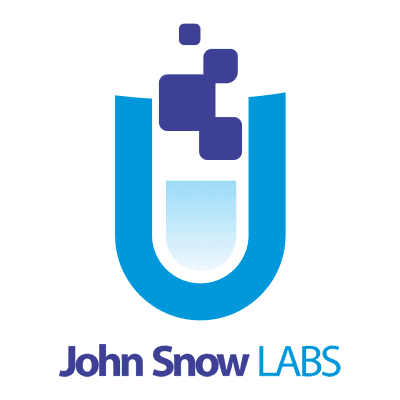

# Colab Setup

In [4]:
! pip install -q pyspark==3.1.2 spark-nlp

! pip install -q spark-nlp-display

In [ ]:
import sparknlp

spark = sparknlp.start(gpu = True) 

from sparknlp.base import *
from sparknlp.annotator import *
import pyspark.sql.functions as F
from sparknlp.training import CoNLL

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

# CoNLL Train & Test Data Import

In [6]:
!wget -q https://raw.githubusercontent.com/gokhanturer/NER_Model_SparkNLP/main/BioNLP09_IOB_train.conll
!wget -q https://raw.githubusercontent.com/gokhanturer/NER_Model_SparkNLP/main/BioNLP09_IOB_test.conll

In [ ]:
with open ("BioNLP09_IOB_train.conll") as f:
  train_data = f.read()

## Train Data

In [7]:
train_data = CoNLL().readDataset(spark, 'BioNLP09_IOB_train.conll')

train_data.show(5)

22/02/20 18:06:18 WARN TaskSetManager: Stage 0 contains a task of very large size (65003 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Reactive oxygen i...|[{document, 0, 13...|[{document, 0, 13...|[{token, 0, 7, Re...|[{pos, 0, 7, NN, ...|[{named_entity, 0...|
|We previously rep...|[{document, 0, 15...|[{document, 0, 15...|[{token, 0, 1, We...|[{pos, 0, 1, NN, ...|[{named_entity, 0...|
|However , the sou...|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 6, Ho...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
|5 - LOX and 5 - L...|[{document, 0, 12...|[{document, 0, 12...|[{token, 0, 0, 5,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
|Stimulation of ly...|[{document, 0, 29...|[{document, 0, 29...|[{token, 0, 10, S...|[{pos, 0, 10, NN,..

In [ ]:
train_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+------------+---+---------+
|       token|pos|ner_label|
+------------+---+---------+
|    Reactive| NN|        O|
|      oxygen| NN|        O|
|intermediate| NN|        O|
|           -| NN|        O|
|   dependent| NN|        O|
|          NF| NN|        O|
|           -| NN|        O|
|      kappaB| NN|        O|
|  activation| NN|        O|
|          by| NN|        O|
| interleukin| NN|B-Protein|
|           -| NN|I-Protein|
|       1beta| NN|I-Protein|
|    requires| NN|        O|
|           5| NN|B-Protein|
|           -| NN|I-Protein|
|lipoxygenase| NN|I-Protein|
|          or| NN|        O|
|       NADPH| NN|        O|
|     oxidase| NN|        O|
+------------+---+---------+
only showing top 20 rows



In [ ]:
train_data.select(F.explode(F.arrays_zip("token.result","label.result")).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy("ground_truth").count().orderBy("count", ascending=False).show(100,truncate=False)

In [8]:
#conll_data.select(F.countDistinct("label.result")).show()
#conll_data.groupBy("label.result").count().show(truncate=False)

train_data = train_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

#train_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          #.select(F.expr("cols['0']").alias("token"),
                  #F.expr("cols['1']").alias("ground_truth"))\
          #.groupBy('ground_truth')\
          #.count()\
          #.orderBy('count', ascending=False)\
          #.show(100,truncate=False)

## Test Data

In [ ]:
with open ("BioNLP09_IOB_test.conll") as f:
  test_data = f.read()
#print (test_data[:500])

In [9]:
test_data = CoNLL().readDataset(spark, 'BioNLP09_IOB_test.conll')
#test_data.show(5)

In [ ]:
test_data.select(F.explode(F.arrays_zip("token.result","label.result")).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy("ground_truth").count().orderBy("count", ascending=False).show(100,truncate=False)

In [10]:
glove_embeddings = WordEmbeddingsModel.pretrained()\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ / ]Download done! Loading the resource.
[OK!]


# NERDL Model with Glove_100d

In [11]:
glove_embeddings.transform(test_data).write.parquet('/content/drive/MyDrive/Parquet/testdata_bionlp09.parquet')

In [11]:
nerTagger = NerDLApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(9)\
    .setLr(0.002)\
    .setDropout(0.5)\
    .setBatchSize(15)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setTestDataset('/content/drive/MyDrive/Parquet/testdata_bionlp09.parquet')\
    .setEnableMemoryOptimizer(False)

ner_pipeline = Pipeline(stages=[
      glove_embeddings,
      nerTagger
])

In [12]:
 %%time

ner_model = ner_pipeline.fit(train_data)

22/02/20 18:07:50 WARN TaskSetManager: Stage 3 contains a task of very large size (65003 KiB). The maximum recommended task size is 1000 KiB.
22/02/20 18:08:10 WARN TaskSetManager: Stage 4 contains a task of very large size (65003 KiB). The maximum recommended task size is 1000 KiB.
2022-02-20 18:08:29.179531: I external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-20 18:08:31.162719: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 18:08:31.194193: I external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-20 18:0

Training started - total epochs: 9 - lr: 0.002 - batch size: 15 - labels: 3 - chars: 80 - training examples: 4711
Epoch 1/9 started, lr: 0.002, dataset size: 4711
Epoch 1/9 - 147.58s - loss: 2038.943 - batches: 316
Quality on test dataset: 
time to finish evaluation: 18.39s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Protein	 3167	 683	 911	 0.8225974	 0.7766062	 0.7989405
B-Protein	 2747	 659	 842	 0.8065179	 0.7653943	 0.7854182
tp: 5914 fp: 1342 fn: 1753 labels: 2
Macro-average	 prec: 0.8145577, rec: 0.77100027, f1: 0.79218066
Micro-average	 prec: 0.8150496, rec: 0.7713578, f1: 0.792602
Epoch 2/9 started, lr: 0.0019900498, dataset size: 4711
Epoch 2/9 - 142.76s - loss: 910.4699 - batches: 316
Quality on test dataset: 
time to finish evaluation: 16.53s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Protein	 3360	 834	 718	 0.8011445	 0.8239333	 0.8123791
B-Protein	 3036	 743	 553	 0.80338717	 0.84591806	 0.82410425
tp: 6396 fp: 1577 fn: 1271 labels: 2
Macro-average	 prec: 0.8022658, rec: 0.83492565, f1: 

In [23]:
!cd ~/annotator_logs/ && ls -lt

total 24
-rw-r--r-- 1 root root 4564 Feb 20 17:47 NerDLApproach_de76987bad55.log
-rw-r--r-- 1 root root 4554 Feb 20 17:11 NerDLApproach_5fbeff984cd0.log
-rw-r--r-- 1 root root 4567 Feb 20 16:42 NerDLApproach_1415e230cd77.log


In [24]:
!cat ~/annotator_logs/NerDLApproach_de76987bad55.log


Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 9 - lr: 0.002 - batch size: 15 - labels: 3 - chars: 80 - training examples: 4711


Epoch 1/9 started, lr: 0.002, dataset size: 4711


Epoch 1/9 - 167.27s - loss: 2205.5518 - batches: 316
Quality on test dataset: 
time to finish evaluation: 17.23s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Protein	 3217	 784	 861	 0.804049	 0.7888671	 0.7963857
B-Protein	 2736	 636	 853	 0.8113879	 0.76232934	 0.78609395
tp: 5953 fp: 1420 fn: 1714 labels: 2
Macro-average	 prec: 0.80771846, rec: 0.7755982, f1: 0.79133254
Micro-average	 prec: 0.8074054, rec: 0.7764445, f1: 0.79162234


Epoch 2/9 started, lr: 0.0019900498, dataset size: 4711


Epoch 2/9 - 169.95s - loss: 958.2137 - batches: 316
Quality on test dataset: 
time to finish evaluation: 16.87s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Protein	 3290	 729	 788	 0.8186116	 0.806768	 0.8126467
B-Protein	 2935	 576	 654	 0.8359442	 0.81777656	 0.8267606
tp: 6225 fp: 1305 fn: 

In [ ]:
import pyspark.sql.functions as F

predictions = ner_model.transform(test_data)

predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).show(truncate=False)

In [26]:
from sklearn.metrics import classification_report, accuracy_score

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))
print (accuracy_score(preds_df['ground_truth'], preds_df['prediction']))

              precision    recall  f1-score   support

   B-Protein       0.86      0.87      0.87      3589
   I-Protein       0.84      0.86      0.85      4078
           O       0.99      0.98      0.98     66957

    accuracy                           0.97     74624
   macro avg       0.90      0.91      0.90     74624
weighted avg       0.97      0.97      0.97     74624

0.9716713121783876


### Saving the Trained Model

In [27]:
ner_model.stages

[WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_79a590c3689d]

In [28]:
ner_model.stages[1].write().overwrite().save("/content/drive/MyDrive/BioNLP09_IOB_NER_Model/Ner_glove_100d_e9_b10_lr0.02_90_91")

# Prediction Pipeline

In [32]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')
    
glove_embeddings = WordEmbeddingsModel.pretrained()\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

loaded_ner_model = NerDLModel.load("/content/drive/MyDrive/BioNLP09_IOB_NER_Model/Ner_glove_100d_e9_b10_lr0.02_90_91")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
      document,
      sentence,
      token,
      glove_embeddings,
      loaded_ner_model,
      converter
  ])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [33]:
text = '''
MACROPHAGES ARE MONONUCLEAR phagocytes that reside within almost all tissues including adipose tissue, where they are identifiable as distinct populations with tissue-specific morphology, localization, and function (1). During the process of atherosclerosis, monocytes adhere to the endothelium and migrate into the intima, express scavenger receptors, and bind internalized lipoprotein particles resulting in the formation of foam cells (2). In obesity, adipose tissue contains an increased number of resident macrophages (3, 4). Macrophage accumulation in proportion to adipocyte size may increase the adipose tissue production of proinflammatory and acute-phase molecules and thereby contribute to the pathophysiological consequences of obesity (1, 3). These facts indicate that macrophages play an important role in a variety of diseases. When activated, macrophages release stereotypical profiles of cytokines and biological molecules such as nitric oxide TNF-α, IL-6, and IL-1 (5). TNF-α is a potent chemoattractant (6) and originates predominantly from residing mouse peritoneal macrophages (MPM) and mast cells (7). TNF-α induces leukocyte adhesion and degranulation, stimulates nicotinamide adenine dinucleotide phosphate (NADPH) oxidase, and enhances expression of IL-2 receptors and expression of E-selectin and intercellular adhesion molecules on the endothelium (8). TNF-α also stimulates expression of IL-1, IL-2, IL-6, and platelet-activating factor receptor (9). In addition, TNF-α decreases insulin sensitivity and increases lipolysis in adipocytes (10, 11). IL-6 also increase lipolysis and has been implicated in the hypertriglyceridemia and increased serum free fatty acid levels associated with obesity (12). Increased IL-6 signaling induces the expression of C-reactive protein and haptoglubin in liver (13). Recombinant IL-6 treatment increases atherosclerotic lesion size 5-fold (14). IL-6 also dose-dependently increases macrophage oxidative low-density lipoprotein (LDL) degradation and CD36 mRNA expression in vitro (15). These data clearly indicate that IL-6 and TNF-α are important pathogenetic factors associated with obesity, insulin resistance, and atherosclerosis. However, the factors regulating gene expression of these cytokines in macrophages have not been fully clarified.
'''

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|
MACROPHAGES ARE MONONUCLEAR phagocytes that reside within almost all tissues including adipose t...|
+----------------------------------------------------------------------------------------------------+



In [34]:
preds = prediction_model.transform(sample_data)

result_df = preds.select(F.explode(F.arrays_zip("ner_span.result","ner_span.metadata")).alias("entities")) \
                .select(F.expr("entities['0']").alias("chunk"),
                        F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+--------------+-------+
|chunk         |entity |
+--------------+-------+
|IL-6          |Protein|
|IL-1 (5).     |Protein|
|TNF-α         |Protein|
|IL-2 receptors|Protein|
|IL-2          |Protein|
|IL-6          |Protein|
|insulin       |Protein|
|haptoglubin   |Protein|
|CD36          |Protein|
|IL-6          |Protein|
|insulin       |Protein|
+--------------+-------+



In [35]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

[('MACROPHAGES', 'O'),
 ('ARE', 'O'),
 ('MONONUCLEAR', 'O'),
 ('phagocytes', 'O'),
 ('that', 'O'),
 ('reside', 'O'),
 ('within', 'O'),
 ('almost', 'O'),
 ('all', 'O'),
 ('tissues', 'O'),
 ('including', 'O'),
 ('adipose', 'O'),
 ('tissue', 'O'),
 (',', 'O'),
 ('where', 'O'),
 ('they', 'O'),
 ('are', 'O'),
 ('identifiable', 'O'),
 ('as', 'O'),
 ('distinct', 'O'),
 ('populations', 'O'),
 ('with', 'O'),
 ('tissue-specific', 'O'),
 ('morphology', 'O'),
 (',', 'O'),
 ('localization', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('function', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (').', 'O'),
 ('During', 'O'),
 ('the', 'O'),
 ('process', 'O'),
 ('of', 'O'),
 ('atherosclerosis', 'O'),
 (',', 'O'),
 ('monocytes', 'O'),
 ('adhere', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('endothelium', 'O'),
 ('and', 'O'),
 ('migrate', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('intima', 'O'),
 (',', 'O'),
 ('express', 'O'),
 ('scavenger', 'O'),
 ('receptors', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('bind', 'O'),
 ('internalized', 'O'),
 

In [36]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df.head(15)

,sent_id,token,start,end,ner
0,0,MACROPHAGES,1,11,O
1,0,ARE,13,15,O
2,0,MONONUCLEAR,17,27,O
3,0,phagocytes,29,38,O
4,0,that,40,43,O
5,0,reside,45,50,O
6,0,within,52,57,O
7,0,almost,59,64,O
8,0,all,66,68,O
9,0,tissues,70,76,O


### Highlight Entities

In [37]:
ann_text = light_model.fullAnnotate(text)[0]
ann_text.keys()

dict_keys(['document', 'ner_span', 'token', 'ner', 'embeddings', 'sentence'])

In [38]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()
print ('Standard Output')
visualiser.display(ann_text, label_col='ner_span', document_col='document')

Standard Output


# STREAMLIT

In [1]:
! pip install -q pyspark==3.1.2 spark-nlp

! pip install -q spark-nlp-display

In [2]:
!pip install streamlit

!pip install pyngrok==4.1.1

In [3]:
! wget https://raw.githubusercontent.com/gokhanturer/NER_Model_SparkNLP/main/BioNLP09_IOB_NER_MODEL_90_91.py

--2022-02-20 19:03:30--  https://raw.githubusercontent.com/gokhanturer/NER_Model_SparkNLP/main/BioNLP09_IOB_NER_MODEL_90_91.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9089 (8.9K) [text/plain]
Saving to: ‘BioNLP09_IOB_NER_MODEL_90_91.py’

BioNLP09_IOB_NER_MO 100%[===================>]   8.88K  --.-KB/s    in 0s      

2022-02-20 19:03:30 (65.8 MB/s) - ‘BioNLP09_IOB_NER_MODEL_90_91.py’ saved [9089/9089]



In [4]:
!ngrok authtoken 24jtZ2Watn1mc1bSG6v19fel7p1_2bYeRjRkniKqqhfgRs6ub

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [5]:
!streamlit run BioNLP09_IOB_NER_MODEL_90_91.py &>/dev/null&

In [6]:
from pyngrok import ngrok

public_url = ngrok.connect(port='8501')
public_url

'http://21a0-35-233-139-73.ngrok.io'

In [ ]:
!killall ngrok

# Zipping Model

In [7]:
import shutil

shutil.make_archive("/content/drive/MyDrive/BioNLP09_IOB_NER_Model/Ner_glove_100d_e9_b10_lr0.02_90_91", 'zip', "/content/drive/MyDrive/BioNLP09_IOB_NER_Model/Ner_glove_100d_e9_b10_lr0.02_90_91")

'/content/drive/MyDrive/BioNLP09_IOB_NER_Model/Ner_glove_100d_e9_b10_lr0.02_90_91.zip'